## Imports and inital setup

In [270]:
# Imports
import pandas as pd

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras import layers, models

from sklearn.model_selection import train_test_split
from sklearn.utils import resample

import matplotlib.pyplot as plt

import os
import random
import string
import sys

SEED = 42
MAX_SAMPLES = 200
NUM_CLASSES = 7
NUM_EPOCHS = 2

# File path variables
# please make sure to use the correct path to the meta data file

FILEPATH_JPGS = './../data/jpgs/'
FILEPATH_METADATA="./../data/HAM10000_metadata"
FILEPATH_OUTPUT = './../data/jpgs/'  # Replace with your folder path

### Delets all augmented images in advance

In [271]:
# Define the bash script as a string
bash_script = """
#!/bin/bash

output_folder="./../data/jpgs/"  # Replace with your folder path

# Delete images with the "aug_" prefix
find "$output_folder" -type f -name "aug_*" -delete

echo "Deleted augmented images with 'aug_' prefix in $output_folder"
"""

# Save the bash script to a file
with open('delete_augmented_images.sh', 'w') as script_file:
    script_file.write(bash_script)

# Make the script executable
!chmod +x delete_augmented_images.sh

# Execute the script
!./delete_augmented_images.sh

Deleted augmented images with 'aug_' prefix in ./../data/jpgs/


In [272]:
# Read the metadata file
metadata = pd.read_csv(FILEPATH_METADATA)

# add .jpg to the image_id column
metadata['image_id'] = metadata['image_id'].apply(lambda x: f"{x}.jpg")

# Concatenate the base directory with the image filename to add the full path
metadata['image_path'] = FILEPATH_JPGS + metadata['image_id']

metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,image_path
0,HAM_0000118,ISIC_0027419.jpg,bkl,histo,80.0,male,scalp,vidir_modern,./../data/jpgs/ISIC_0027419.jpg
1,HAM_0000118,ISIC_0025030.jpg,bkl,histo,80.0,male,scalp,vidir_modern,./../data/jpgs/ISIC_0025030.jpg
2,HAM_0002730,ISIC_0026769.jpg,bkl,histo,80.0,male,scalp,vidir_modern,./../data/jpgs/ISIC_0026769.jpg
3,HAM_0002730,ISIC_0025661.jpg,bkl,histo,80.0,male,scalp,vidir_modern,./../data/jpgs/ISIC_0025661.jpg
4,HAM_0001466,ISIC_0031633.jpg,bkl,histo,75.0,male,ear,vidir_modern,./../data/jpgs/ISIC_0031633.jpg


## Splitting the data in train, validation and test sets

In [273]:
# Splitting the data into train, validation and test using train_test_split

# Split the data into two subsets: train and temp (60% train, 40% temp)
train_df, temp_df = train_test_split(metadata, test_size=0.4, stratify=metadata['dx'], random_state=SEED)

# Split the temp data into validation and test sets (50% each)
validation_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['dx'], random_state=SEED)

# resetting the index
train_df = train_df.reset_index(drop=True)
validation_df = validation_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

display(
    train_df.shape,
    validation_df.shape,
    test_df.shape
)

(6009, 9)

(2003, 9)

(2003, 9)

## Tackling Class imbalances in the training set

### Setting up the image data generators

In [274]:
# Setting up the Image Data Generator for the train data set - including augmentation

datagen_train = ImageDataGenerator(
    #rescale=1.0 / 255.0,  # Rescale pixel values to [0, 1], important for CNNs to perform better, deactivate to see images down below
    rotation_range=40,   # Randomly rotate images by up to 40 degrees
    width_shift_range=0.2,  # Randomly shift the width by up to 20%
    height_shift_range=0.2, # Randomly shift the height by up to 20%
    shear_range=0.2,     # Apply shear transformations
    zoom_range=0.2,      # Apply zoom transformations
    horizontal_flip=True, # Randomly flip images horizontally
    fill_mode='nearest'  # Fill in missing pixels with the nearest value
)

# Create an ImageDataGenerator for validation data (no augmentation)

datagen_validation = ImageDataGenerator(
    #rescale=1.0 / 255.0 #see above
)


### Helper Function: Load images from directory and return as numpy array

In [275]:
from PIL import Image
import numpy as np

def load_and_preprocess_image(image_path, target_size=(128, 128)):
    # Load the image using PIL
    image = Image.open(image_path)
    
    # Resize the image to the target size
    image = image.resize(target_size)
    
    # Convert the PIL image to a NumPy array
    image_array = np.array(image)
    
    # Perform any additional preprocessing steps here
    # For example, you can normalize pixel values to [0, 1]
    # image_array = image_array / 255.0
    
    return image_array

In [276]:
# Define a function to generate a random string for image ID prefixes
def generate_random_string(length=6):
    letters_and_digits = string.ascii_letters + string.digits
    return ''.join(random.choice(letters_and_digits) for i in range(length))

In [277]:
# Create separate DataFrames for each class 

class_dataframes = {}
for class_label in train_df['dx'].unique():
    class_dataframes[class_label] = train_df[train_df['dx'] == class_label]
    print(f"Class {class_label} has {class_dataframes[class_label].shape[0]} samples")
    #display(class_dataframes[class_label].head())

Class nv has 4023 samples
Class bcc has 308 samples
Class mel has 668 samples
Class akiec has 196 samples
Class vasc has 85 samples
Class bkl has 660 samples
Class df has 69 samples


In [278]:
# Initialize a dictionary to keep track of the number of augmented images per class
class_augmentation_counts = {class_label: 0 for class_label in class_dataframes.keys()}

# Create a list to store DataFrames for each class
augmented_dataframes = []

# Apply data augmentation for classes with few examples, trim classes with too many examples
for class_label, class_df in class_dataframes.items():
    
    # Describing the overall progress
    print(f"\nChecking class {class_label}...")

    # Check if the class has already reached the maximum number of augmented images // TO BE DELETED
    #if class_augmentation_counts[class_label] >= MAX_SAMPLES:
    #    continue

    # Calculate the number of images needed to reach MAX_SAMPLES for this class
    images_needed = MAX_SAMPLES - class_df.shape[0]
    
    # If images_needed is negative, randomly select MAX_SAMPLES from the class_df
    if images_needed < 0:
        print(f"> Result: Class {class_label} was reduced to {MAX_SAMPLES} samples")
        reduced_df = class_df.sample(n=MAX_SAMPLES, random_state=SEED)
        augmented_dataframes.append(reduced_df)
        continue
    # If images_needed is zero, skip this class
    elif images_needed == 0:
        print(f"> Result: Class {class_label} already has exactly {MAX_SAMPLES} samples")
        augmented_dataframes.append(class_df)
        continue

    # Generate augmented data - this part only runs if images_needed is positive
    print(f"> Result: Class {class_label} needs {images_needed} more images")
    augmented_dataframes.append(class_df)

    while class_augmentation_counts[class_label] <= images_needed:

        # Describing the subprocess progress for each class
        sys.stdout.write(f"\rProgress: {class_augmentation_counts[class_label]}/{images_needed}")
        sys.stdout.flush()

        # Randomly select an image from the class_df
        i = random.randint(0, class_df.shape[0] - 1)
        image_path = class_df.iloc[i]['image_path']

        # Load and preprocess the image
        img = load_and_preprocess_image(image_path)

        # Apply data augmentation via generator
        augmented_img = datagen_train.random_transform(img)

        # Create a new image ID with prefix
        augmented_image_id = f'aug_{generate_random_string()}' + os.path.basename(image_path)

        # Create a new image path with the augmented image ID as string
        augmented_image_path = FILEPATH_JPGS + augmented_image_id
        
        # Create a new DataFrame for the augmented data for this instance only
        augmented_instance_df = class_df.iloc[i:i+1].copy()
        
        # Reset the index of the new DataFrame
        augmented_instance_df.reset_index(drop=True, inplace=True)

        # Update the "image_id" column with the augmented image ID
        augmented_instance_df.at[0, 'image_id'] = augmented_image_id
        
        # Update the "image_path" column with the augmented image path
        augmented_instance_df.at[0, 'image_path'] = augmented_image_path
        
        # Append the augmented DataFrame for this instance to the list
        augmented_dataframes.append(augmented_instance_df)

        # Save the augmented image to the output folder
        augmented_image_path = os.path.join(FILEPATH_OUTPUT, augmented_image_id)
        plt.imsave(augmented_image_path, augmented_img)

        # Update the counter for the class
        class_augmentation_counts[class_label] += 1

        #if class_augmentation_counts[class_label] > 18:
        #    break

# Combine all augmented DataFrames into a single DataFrame
balanced_train_df = pd.concat(augmented_dataframes, ignore_index=True)

balanced_train_df.shape



Checking class nv...
> Result: Class nv was reduced to 200 samples

Checking class bcc...
> Result: Class bcc was reduced to 200 samples

Checking class mel...
> Result: Class mel was reduced to 200 samples

Checking class akiec...
> Result: Class akiec needs 4 more images
Progress: 4/4
Checking class vasc...
> Result: Class vasc needs 115 more images
Progress: 115/115
Checking class bkl...
> Result: Class bkl was reduced to 200 samples

Checking class df...
> Result: Class df needs 131 more images
Progress: 131/131

(1403, 9)

In [279]:
# counting the number of samples per class
balanced_train_df['dx'].value_counts()

dx
akiec    201
vasc     201
df       201
nv       200
bcc      200
mel      200
bkl      200
Name: count, dtype: int64

In [280]:
# Checking what's going on in the foleder

def count_files_in_folder(folder_path):
    # Initialize counters
    total_files = 0
    aug_files = 0

    # Check if the folder exists
    if os.path.exists(folder_path):
        # List all files in the folder
        files = os.listdir(folder_path)
        
        # Count all files and files starting with "aug_"
        for file in files:
            total_files += 1
            if file.startswith("aug_"):
                aug_files += 1

        # Display the counts
        print(f"Total files in folder: {total_files}")
        print(f"Files starting with 'aug_': {aug_files}")
    else:
        print(f"Folder '{folder_path}' does not exist.")

# Example usage:
folder_path = "./../data/jpgs/"  # Replace with your folder path
count_files_in_folder(folder_path)


Total files in folder: 10268
Files starting with 'aug_': 253


In [281]:
balanced_train_df.sample(15)

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,image_path
521,HAM_0001349,ISIC_0024351.jpg,mel,histo,70.0,female,lower extremity,rosendahl,./../data/jpgs/ISIC_0024351.jpg
230,HAM_0005981,ISIC_0027371.jpg,bcc,histo,65.0,male,face,rosendahl,./../data/jpgs/ISIC_0027371.jpg
834,HAM_0006193,ISIC_0029877.jpg,vasc,consensus,80.0,male,lower extremity,vidir_molemax,./../data/jpgs/ISIC_0029877.jpg
1082,HAM_0002169,ISIC_0031593.jpg,bkl,histo,65.0,male,upper extremity,rosendahl,./../data/jpgs/ISIC_0031593.jpg
278,HAM_0005396,ISIC_0032834.jpg,bcc,histo,75.0,male,abdomen,vidir_modern,./../data/jpgs/ISIC_0032834.jpg
234,HAM_0004536,ISIC_0030314.jpg,bcc,histo,40.0,female,back,vidir_modern,./../data/jpgs/ISIC_0030314.jpg
476,HAM_0000375,ISIC_0030238.jpg,mel,histo,45.0,male,back,rosendahl,./../data/jpgs/ISIC_0030238.jpg
405,HAM_0006214,ISIC_0032190.jpg,mel,histo,60.0,male,upper extremity,vidir_modern,./../data/jpgs/ISIC_0032190.jpg
790,HAM_0007308,ISIC_0026848.jpg,akiec,histo,55.0,male,face,rosendahl,./../data/jpgs/ISIC_0026848.jpg
289,HAM_0007248,ISIC_0025102.jpg,bcc,histo,70.0,male,lower extremity,vidir_modern,./../data/jpgs/ISIC_0025102.jpg


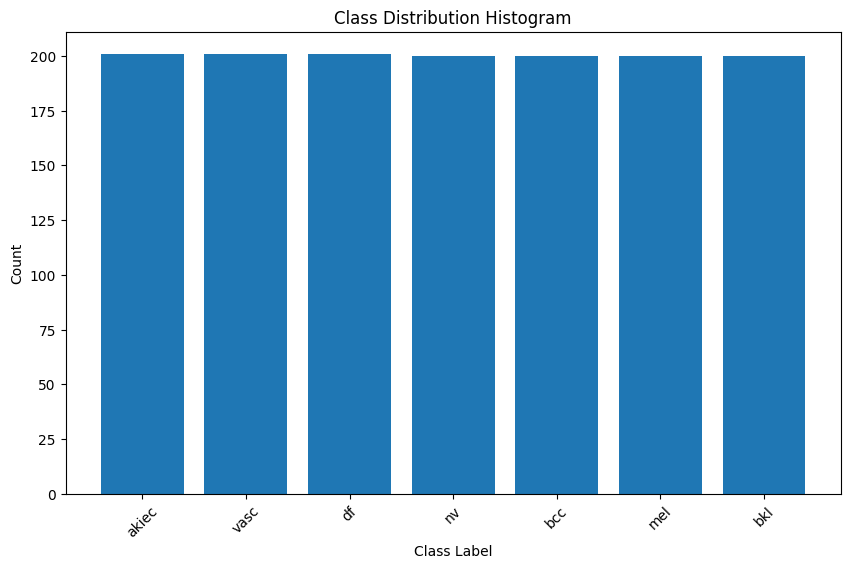

In [282]:
# Count the occurrences of each class in the DataFrame
class_counts = balanced_train_df['dx'].value_counts()

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.title('Class Distribution Histogram')
plt.xticks(rotation=45)
plt.show()

In [283]:
validation_generator = datagen_validation.flow_from_dataframe(
    dataframe=validation_df,
    directory=FILEPATH_JPGS,
    x_col="image_id",
    y_col="dx",
    #subset="validation",
    class_mode="categorical",
    target_size=(128, 128),
    batch_size=32
)

Found 2003 validated image filenames belonging to 7 classes.


"Found 2003 validated image filenames belonging to 7 classes."
--> validated means, that the image is in the right format and can be loaded by the model from the directory and matched with an entry in the csv file

## Adding an neural network model to test the data

In [284]:
# Define super basic neural network architecture
model = tf.keras.models.Sequential([
    # Input layer
    tf.keras.layers.InputLayer(input_shape=(128, 128, 3)),

    # Convolutional block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    # Convolutional block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    # Convolutional block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    # Flattening the output of the convolutional layers
    tf.keras.layers.Flatten(),

    # Dense (fully connected) layers
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),

    # Output layer
    tf.keras.layers.Dense(7, activation='softmax')
])


# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model architecture
model.summary()




Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 14, 14, 128)     

In [285]:
# Train the model

history = model.fit(
    datagen_train.flow_from_dataframe(
        dataframe=balanced_train_df,
        directory=FILEPATH_JPGS,
        x_col="image_id",
        y_col="dx",
        class_mode="categorical",
        target_size=(128, 128),
        batch_size=32
    ),
    validation_data=validation_generator,
    epochs=NUM_EPOCHS,
    verbose=1  # Adjust verbosity level
)

Found 1403 validated image filenames belonging to 7 classes.
Epoch 1/2
44/44 [==============================] - 21s 479ms/step - loss: 29.5188 - accuracy: 0.1996 - val_loss: 1.9010 - val_accuracy: 0.2122
Epoch 2/2
44/44 [==============================] - 20s 462ms/step - loss: 1.8952 - accuracy: 0.2038 - val_loss: 1.4829 - val_accuracy: 0.3844
